# Assignment 1 --Sentiment Analysis for IMDB--

Installing textblob and mount the project to my drive

In [18]:
!pip -q install nltk textblob

from google.colab import drive
drive.mount('/content/drive')

import os
project_path = "/content/drive/MyDrive/IMDB_Project"
os.makedirs(project_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Include all necessary imports in this cell

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [20]:
df = pd.read_csv(f"{project_path}/IMDB Dataset.csv")

Uploaded the dataset


Check missing values

In [21]:
df.isnull().sum()

,0
review,0
sentiment,0


Check duplicates

In [22]:
df.duplicated().sum()

np.int64(418)

Class balance

In [23]:
df["sentiment"].value_counts()

,count
sentiment,
positive,25000
negative,25000


Simple visualization

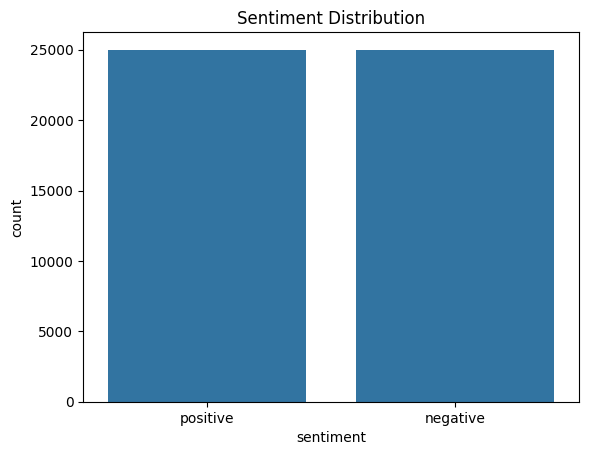

In [24]:
import seaborn as sns
sns.countplot(x="sentiment", data=df)
plt.title("Sentiment Distribution")
plt.show()

Text Preprocessing

In [25]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"<br\s*/?>", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["review_clean"] = df["review"].astype(str).apply(clean_text)

Feature Engineering

In [26]:
sia = SentimentIntensityAnalyzer()

def extract_features(text):
    v = sia.polarity_scores(text)
    tb = TextBlob(text).sentiment
    return [
        v["neg"],
        v["neu"],
        v["pos"],
        v["compound"],
        tb.polarity,
        tb.subjectivity
    ]

#Converting the sentiments (negative ->0 & positive ->1 )
X = np.array(df["review_clean"].apply(extract_features).tolist())
y = df["sentiment"].map({"negative":0, "positive":1}).values


In [27]:
pd.DataFrame(X).to_csv(f"{project_path}/features.csv", index=False)

Split out dataset into Train/val/Test

In [28]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.5, random_state=42, stratify=y_trainval
)

Initialize the parameters

In [29]:
np.random.seed(42)

input_size = X_train.shape[1]
hidden_size = 64
output_size = 1

W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
b1 = np.zeros((1, hidden_size))

W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
b2 = np.zeros((1, output_size))

learning_rate = 0.05
epochs = 500

Activation Functions

In [30]:
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

Training using logistic Regressison

In [31]:
train_losses = []
val_losses = []

for epoch in range(epochs):

    # Forward Propagation
    Z1 = X_train @ W1 + b1
    A1 = relu(Z1)
    Z2 = A1 @ W2 + b2
    A2 = sigmoid(Z2)

    m = y_train.shape[0]

    y_train_reshaped = y_train.reshape(-1,1)
    # Loss
    loss = - (1/m) * np.sum(
        y_train_reshaped*np.log(A2+1e-8) +
        (1-y_train_reshaped)*np.log(1-A2+1e-8)
    )
    train_losses.append(loss)

    # Backward Propagation
    dZ2 = A2 - y_train_reshaped
    dW2 = (1/m) * A1.T @ dZ2
    db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)

    dA1 = dZ2 @ W2.T
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = (1/m) * X_train.T @ dZ1
    db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)

    # Update of the parameters
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    # Validation
    Z1_val = X_val @ W1 + b1
    A1_val = relu(Z1_val)
    Z2_val = A1_val @ W2 + b2
    A2_val = sigmoid(Z2_val)

    val_loss = - (1/y_val.shape[0]) * np.sum(
        y_val.reshape(-1,1)*np.log(A2_val+1e-8) +
        (1-y_val.reshape(-1,1))*np.log(1-A2_val+1e-8)
    )
    val_losses.append(val_loss)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Train {loss:.4f} | Val {val_loss:.4f}")

Epoch 0: Train 0.8194 | Val 0.7721
Epoch 20: Train 0.5862 | Val 0.5847
Epoch 40: Train 0.5676 | Val 0.5678
Epoch 60: Train 0.5601 | Val 0.5605
Epoch 80: Train 0.5542 | Val 0.5548
Epoch 100: Train 0.5490 | Val 0.5496
Epoch 120: Train 0.5441 | Val 0.5448
Epoch 140: Train 0.5396 | Val 0.5403
Epoch 160: Train 0.5355 | Val 0.5362
Epoch 180: Train 0.5317 | Val 0.5325
Epoch 200: Train 0.5282 | Val 0.5290
Epoch 220: Train 0.5249 | Val 0.5258
Epoch 240: Train 0.5220 | Val 0.5228
Epoch 260: Train 0.5192 | Val 0.5200
Epoch 280: Train 0.5166 | Val 0.5175
Epoch 300: Train 0.5143 | Val 0.5151
Epoch 320: Train 0.5120 | Val 0.5129
Epoch 340: Train 0.5100 | Val 0.5108
Epoch 360: Train 0.5081 | Val 0.5089
Epoch 380: Train 0.5062 | Val 0.5071


Evaluation

In [32]:
Z1_test = X_test @ W1 + b1
A1_test = relu(Z1_test)
Z2_test = A1_test @ W2 + b2
A2_test = sigmoid(Z2_test)

predictions = (A2_test >= 0.5).astype(int)

test_accuracy = np.mean(predictions.flatten() == y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.7548666666666667


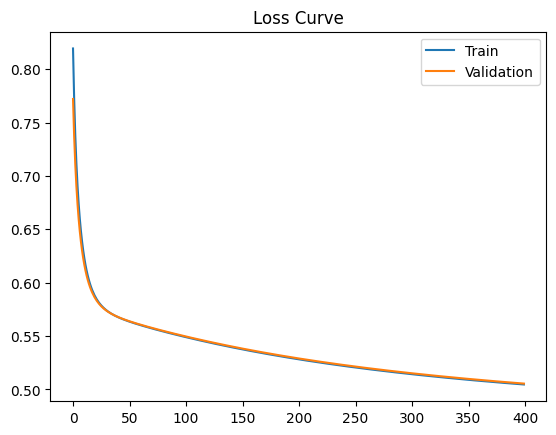

In [33]:
plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["Train","Validation"])
plt.title("Loss Curve")
plt.savefig(f"{project_path}/loss_curves.png")
plt.show()

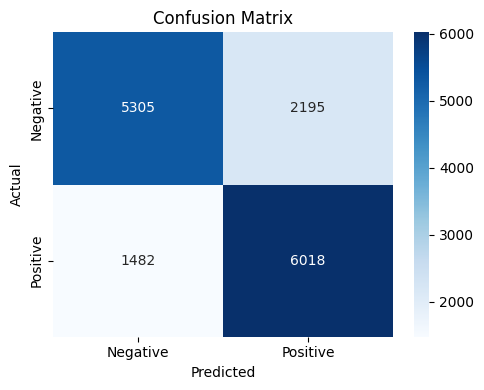

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative','Positive'],
            yticklabels=['Negative','Positive'])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(f"{project_path}/confusion_matrix.png")
plt.show()


In [35]:
submission = pd.DataFrame({
    "id": range(len(predictions)),
    "label": predictions.flatten()
})

submission.to_csv(f"{project_path}/submission.csv", index=False)

In [36]:
import pickle

model_weights = {
    "W1": W1,
    "b1": b1,
    "W2": W2,
    "b2": b2
}

with open(f"{project_path}/best_model.pkl", "wb") as f:
    pickle.dump(model_weights, f)